In [23]:
from pathlib import Path
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt


# Find repo root (directory containing "src/")
ROOT = Path.cwd().resolve()
while not (ROOT / "src").exists():
    if ROOT.parent == ROOT:
        raise RuntimeError("Could not find project root")
    ROOT = ROOT.parent

print("Project root:", ROOT)

Project root: C:\Users\20221529\OneDrive - TU Eindhoven\Desktop\Data Preperation\BigAssignment\data-preparation-2026-group-project


In [18]:
BASE = ROOT / "src" / "project" / "temp" / "biking"

files = {
    "baseline":  BASE / "biking_test_raw.parquet",
    "corrupted": BASE / "biking_test_raw_corrupted.parquet",
    "cleaned":   BASE / "biking_test_raw_corrupted_cleaned.parquet",
}

# sanity check
for name, p in files.items():
    print(name, p.exists(), p)


baseline True C:\Users\20221529\OneDrive - TU Eindhoven\Desktop\Data Preperation\BigAssignment\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw.parquet
corrupted True C:\Users\20221529\OneDrive - TU Eindhoven\Desktop\Data Preperation\BigAssignment\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw_corrupted.parquet
cleaned True C:\Users\20221529\OneDrive - TU Eindhoven\Desktop\Data Preperation\BigAssignment\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw_corrupted_cleaned.parquet


In [20]:
files = {
    "baseline":  BASE / "biking_test_raw.parquet",
    "corrupted": BASE / "biking_test_raw_corrupted.parquet",
    "cleaned":   BASE / "biking_test_raw_corrupted_cleaned.parquet",
}

for name, p in files.items():
    t = pq.read_table(p)
    print(f"{name:10s} rows={t.num_rows:,} cols={t.num_columns}")

baseline   rows=10,294 cols=12
corrupted  rows=10,294 cols=12
cleaned    rows=10,294 cols=12


In [19]:
def ts_lengths(path):
    t = pq.read_table(path, columns=["timestamp"])
    ts = t["timestamp"].to_pylist()
    return np.array([len(x) for x in ts], dtype=int)

for name, fn in [
    ("baseline", "biking_test_raw.parquet"),
    ("corrupted", "biking_test_raw_corrupted.parquet"),
    ("cleaned", "biking_test_raw_corrupted_cleaned.parquet"),
]:
    L = ts_lengths(BASE / fn)
    print(f"{name:10s} n={len(L):,} min/mean/max = {L.min()} / {L.mean():.1f} / {L.max()}")


baseline   n=10,294 min/mean/max = 300 / 300.0 / 300
corrupted  n=10,294 min/mean/max = 300 / 300.0 / 300
cleaned    n=10,294 min/mean/max = 300 / 300.0 / 300


In [21]:
def flatten_seq(table, col, max_workouts=200):
    seqs = table[col].to_pylist()[:max_workouts]
    return np.concatenate([np.asarray(s, dtype=float) for s in seqs if len(s) > 0])

raw   = pq.read_table(BASE / "biking_test_raw.parquet")
corr  = pq.read_table(BASE / "biking_test_raw_corrupted.parquet")
clean = pq.read_table(BASE / "biking_test_raw_corrupted_cleaned.parquet")

for col in ["heart_rate", "derived_speed", "altitude"]:
    x0 = flatten_seq(raw, col)
    x1 = flatten_seq(corr, col)
    x2 = flatten_seq(clean, col)

    n = min(len(x0), len(x1), len(x2))
    x0, x1, x2 = x0[:n], x1[:n], x2[:n]

    d_corr  = float(np.mean(np.abs(x1 - x0)))
    d_clean = float(np.mean(np.abs(x2 - x0)))
    print(f"{col:15s} | corrupted Δ={d_corr:.4f} | cleaned Δ={d_clean:.4f}")

heart_rate      | corrupted Δ=14.6649 | cleaned Δ=17.5321
derived_speed   | corrupted Δ=7.9656 | cleaned Δ=21.8366
altitude        | corrupted Δ=27.4731 | cleaned Δ=23.6203


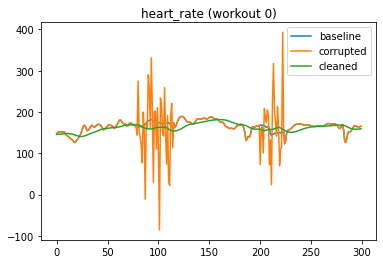

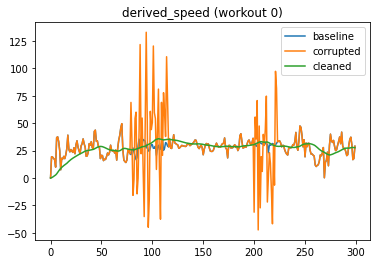

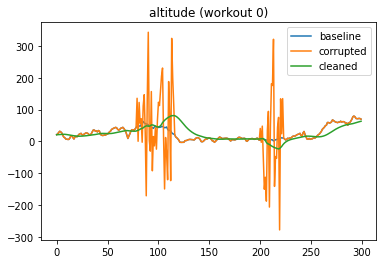

In [28]:
i = 0  # change this index to inspect different workouts

raw   = pq.read_table(BASE / "biking_test_raw.parquet", columns=["heart_rate","derived_speed","altitude"])
corr  = pq.read_table(BASE / "biking_test_raw_corrupted.parquet", columns=["heart_rate","derived_speed","altitude"])
clean = pq.read_table(BASE / "biking_test_raw_corrupted_cleaned.parquet", columns=["heart_rate","derived_speed","altitude"])

def plot_col(col):
    plt.figure()
    plt.plot(raw[col][i].as_py(), label="baseline")
    plt.plot(corr[col][i].as_py(), label="corrupted")
    plt.plot(clean[col][i].as_py(), label="cleaned")
    plt.title(f"{col} (workout {i})")
    plt.legend()
    plt.show()

for c in ["heart_rate", "derived_speed", "altitude"]:
    plot_col(c)

In [27]:
MAX_WORKOUTS = 200

def bad_stats(path, col):
    t = pq.read_table(path, columns=[col])
    seqs = t[col].to_pylist()[:MAX_WORKOUTS]
    arr = np.concatenate([np.asarray(s, dtype=float) for s in seqs if len(s) > 0])
    n = arr.size
    nan = int(np.isnan(arr).sum())
    inf = int(np.isinf(arr).sum())
    return n, nan, inf

paths = {
    "baseline":  BASE / "biking_test_raw.parquet",
    "corrupted": BASE / "biking_test_raw_corrupted.parquet",
    "cleaned":   BASE / "biking_test_raw_corrupted_cleaned.parquet",
}

for col in ["heart_rate", "derived_speed", "altitude"]:
    print("\n", col)
    for name, p in paths.items():
        n, nan, inf = bad_stats(p, col)
        print(f"{name:10s} n={n:,} nan={nan:,} inf={inf:,}")



 heart_rate
baseline   n=60,000 nan=0 inf=0
corrupted  n=60,000 nan=0 inf=0
cleaned    n=60,000 nan=0 inf=0

 derived_speed
baseline   n=60,000 nan=0 inf=0
corrupted  n=60,000 nan=0 inf=0
cleaned    n=60,000 nan=0 inf=0

 altitude
baseline   n=60,000 nan=0 inf=0
corrupted  n=60,000 nan=0 inf=0
cleaned    n=60,000 nan=0 inf=0
